# Model diagnostic evaluation framework
This should be used on a single model with determined parameters, in order to figure out what's giving good and bad prediction and what's happening when the model is being retrained

Below, I'm loading the libraries and functions, along with the dataset

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

def create_folds(number_of_folds,rolling_test_size_ratio,fold_size,df):
    rolling_test_size = int(fold_size*rolling_test_size_ratio)
    print("Creating",number_of_folds,'folds')
    fold_dict = {}
    X_train_dict = {}
    y_train_dict = {}
    X_test_dict = {}
    y_test_dict = {}
    for f_i in range(1,number_of_folds+1):
        train_start_date = (f_i-1) * fold_size
        train_end_date = f_i * fold_size - rolling_test_size
        test_start_date = f_i * fold_size - rolling_test_size
        test_end_date =  f_i * fold_size
        
        fold = df.loc[(df['date_id'] < test_end_date)& (df['date_id']  >= train_start_date)]
        X_train = df.loc[(df['date_id'] < train_end_date)& (df['date_id']  >= train_start_date)][X_columns]
        y_train = df.loc[(df['date_id'] < train_end_date)& (df['date_id']  >= train_start_date)][['target']]
        
        X_test =  df.loc[(df['date_id'] < test_end_date)& (df['date_id']  >=  test_start_date )][X_columns]
        y_test = df.loc[(df['date_id'] < test_end_date)& (df['date_id']   >=  test_start_date )][['target']]
        if f_i == number_of_folds:
            fold = df.loc[(df['date_id'] <= test_end_date)& (df['date_id']  >= train_start_date)]
            X_test =  df.loc[(df['date_id'] <= test_end_date)& (df['date_id']  >=  test_start_date )][X_columns]
            y_test = df.loc[(df['date_id'] <= test_end_date)& (df['date_id']   >=  test_start_date )][['target']]
        fold_dict[f_i] = fold.copy()
        
        X_train_dict[f_i] =  X_train.copy()
        y_train_dict[f_i] =  y_train.copy()
        
        X_test_dict[f_i] =  X_test.copy()
        y_test_dict[f_i] =  y_test.copy()
    return fold_dict.copy(),X_train_dict.copy(), y_train_dict.copy(),X_test_dict.copy(), y_test_dict.copy()


def evaluate_folds(df,fold_dict,X_train_dict, y_train_dict,X_test_dict, y_test_dict,model):
            for f_i in range(1,number_of_folds+1):
                start_fold = time.time()
                # Model is pretrained with the training data
                X_seconds_list = []
                feature_dict = {}
                importance_type_list = ['weight','gain','cover','total_gain','total_cover']
                
                # Setting up the dataframes
                X_train_original = X_train_dict[f_i].copy()
                y_train_original = y_train_dict[f_i].copy()
                X_current_dataset = X_train_dict[f_i].copy()
                y_current_dataset = y_train_dict[f_i].copy()
                
                # Training the model and giving predictions on the test set
                model.fit(X_train_original , y_train_original)
                y_train_prediction_results = model.predict(X_train_original)
                X_train_original['target_pred'] = list(y_train_prediction_results)
                X_train_original['target']  = y_train_original
                last_day_of_training =  max(X_train_original['date_id'].unique())
                feature_dict[last_day_of_training ] = {}
                for importance_type in importance_type_list:
                    feature_dict[last_day_of_training ][importance_type] = model.get_booster().get_score(importance_type=importance_type ).copy()
                
                
                
                for date_id in sorted(X_test_dict[f_i]['date_id'].unique()):
                    # Retraining the model with previous day data
                    test_start_date_id =  min(X_test_dict[f_i]['date_id'].unique())
                    if date_id > test_start_date_id:
                        feature_dict[date_id] = {}
                        X_previous_day_test = X_test_dict[f_i][X_test_dict[f_i]['date_id'] == date_id - 1].copy()
                        y_previous_day_test =  y_test_dict[f_i][X_test_dict[f_i]['date_id'] == date_id - 1].copy()
                        
                        # Retraining the model
                        X_current_dataset = pd.concat([X_current_dataset,X_previous_day_test ]).reset_index(drop=True).copy()
                        y_current_dataset  = pd.concat([y_current_dataset ,y_previous_day_test]).reset_index(drop=True).copy()
                        model.fit(X_current_dataset , y_current_dataset, xgb_model =  model.get_booster())
                        
                        # Saving the model information after retraining
                        for importance_type in importance_type_list:
                            feature_dict[date_id][importance_type] = model.get_booster().get_score(importance_type=importance_type ).copy()        
                    
                    #Predicting the current day data
                    X_day_test = X_test_dict[f_i][X_test_dict[f_i]['date_id'] == date_id].copy()
                    y_day_test = y_test_dict[f_i][X_test_dict[f_i]['date_id'] == date_id].copy()
                    
                    # Predicting for each batch of 10 seconds
                    for seconds_in_bucket in sorted(list(X_day_test['seconds_in_bucket'].unique())):
                        X_seconds_test = X_day_test[X_day_test['seconds_in_bucket'] == seconds_in_bucket].copy()
                        y_seconds_test = y_day_test[X_day_test['seconds_in_bucket'] == seconds_in_bucket].copy()
  
                        # Testing predictions
                        X_seconds_test['target_pred'] = list(model.predict(X_seconds_test))
                        X_seconds_test['target'] = y_seconds_test.copy()
                        X_seconds_list.append(X_seconds_test.copy())
                    end_fold = time.time()
                    print('Date:',date_id,'from',min( X_test_dict[f_i]['date_id'].unique()),'to', max(X_test_dict[f_i]['date_id'].unique()),'| Total time spent on this fold',np.round((end_fold - start_fold)/60,2),'minutes ****')
                
            return  X_train_original.copy(), pd.concat(X_seconds_list).copy(),feature_dict

Loading dataset and introducing features

In [60]:
dtypes = {
    'stock_id' : np.uint8,
    'date_id' : np.uint16,
    'seconds_in_bucket' : np.uint16,
    'imbalance_buy_sell_flag' : np.int8,
    'time_id' : np.uint16,
}

X_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap','time_id']
y_columns = ['target']


df = pd.read_csv('train.csv', dtype = dtypes).drop(['row_id'], axis = 1)

df['far_price'] = df.apply(
    lambda row: row['reference_price'] if np.isnan(row['far_price']) else row['far_price'],
    axis=1)

df['near_price'] = df.apply(
    lambda row: row['reference_price'] if np.isnan(row['near_price']) else row['near_price'],
    axis=1)

    
df = df.dropna()


In [76]:
df_trade = df[df['date_id'] > 239]
df_trade = df_trade[['stock_id','date_id','seconds_in_bucket','time_id','wap']]
df_trade['predicted_wap'] = df_trade['wap']
df_trade.to_csv('closing_auction_strategy_train_test_data.csv')

In [78]:
df_trade = df[df['date_id'] <= 239]
df_trade.to_csv('closing_auction_ML_train_test_data.csv')

The code below splits the training and the testing set, with the specificed model

In [5]:
number_of_stocks = 200
number_of_bucket_iter = 55
# Creating time series folds
number_of_folds = 1
total_number_of_days = 480
fold_size =  total_number_of_days/number_of_folds
# Test size propoprtion
rolling_test_size_ratio = 0.1

param_dict = {'max_depth':5,'n_estimators':10,'eta':0.001,'min_child':100,'alpha':100,'lambda':100}

# Store the model in the dictionary
model =xgb.XGBRegressor(base_score=0, booster='gbtree',
                         n_estimators=param_dict['n_estimators'],
                         objective="reg:squarederror",
                         max_depth=param_dict['max_depth'],
                         eta=param_dict['eta'],
                         reg_alpha =param_dict['alpha'],
                        reg_lambda =param_dict['lambda'],
                        min_child_weight =param_dict['min_child'])

fold_dict,X_train_dict, y_train_dict,X_test_dict, y_test_dict = create_folds(number_of_folds,rolling_test_size_ratio,fold_size,df.copy())
X_train_df, X_test_df,feature_dict = evaluate_folds(df.copy(),fold_dict.copy(),X_train_dict.copy(), y_train_dict.copy(),X_test_dict.copy(), y_test_dict.copy(),model)

Creating 1 folds
Date: 432 from 432 to 480 | Total time spent on this fold 0.1 minutes ****
Date: 433 from 432 to 480 | Total time spent on this fold 0.2 minutes ****
Date: 434 from 432 to 480 | Total time spent on this fold 0.3 minutes ****
Date: 435 from 432 to 480 | Total time spent on this fold 0.39 minutes ****
Date: 436 from 432 to 480 | Total time spent on this fold 0.49 minutes ****
Date: 437 from 432 to 480 | Total time spent on this fold 0.59 minutes ****
Date: 438 from 432 to 480 | Total time spent on this fold 0.68 minutes ****
Date: 439 from 432 to 480 | Total time spent on this fold 0.78 minutes ****
Date: 440 from 432 to 480 | Total time spent on this fold 0.88 minutes ****
Date: 441 from 432 to 480 | Total time spent on this fold 0.98 minutes ****
Date: 442 from 432 to 480 | Total time spent on this fold 1.08 minutes ****
Date: 443 from 432 to 480 | Total time spent on this fold 1.18 minutes ****
Date: 444 from 432 to 480 | Total time spent on this fold 1.28 minutes ***

In [6]:
X_test_df['absolute_error'] = abs(X_test_df['target'] - X_test_df['target_pred'])
X_train_df['absolute_error'] = abs(X_train_df['target'] - X_train_df['target_pred'])
print("Training set error:",np.round(X_train_df['absolute_error'].mean(),5))
print("Test set error:",np.round(X_test_df['absolute_error'].mean(),5))

Training set error: 6.45994
Test set error: 5.9238


# Feature importance scores during retraining
As model is getting retrained after each full day, I'm plotting how feature importance scores are changing with each day of retraining

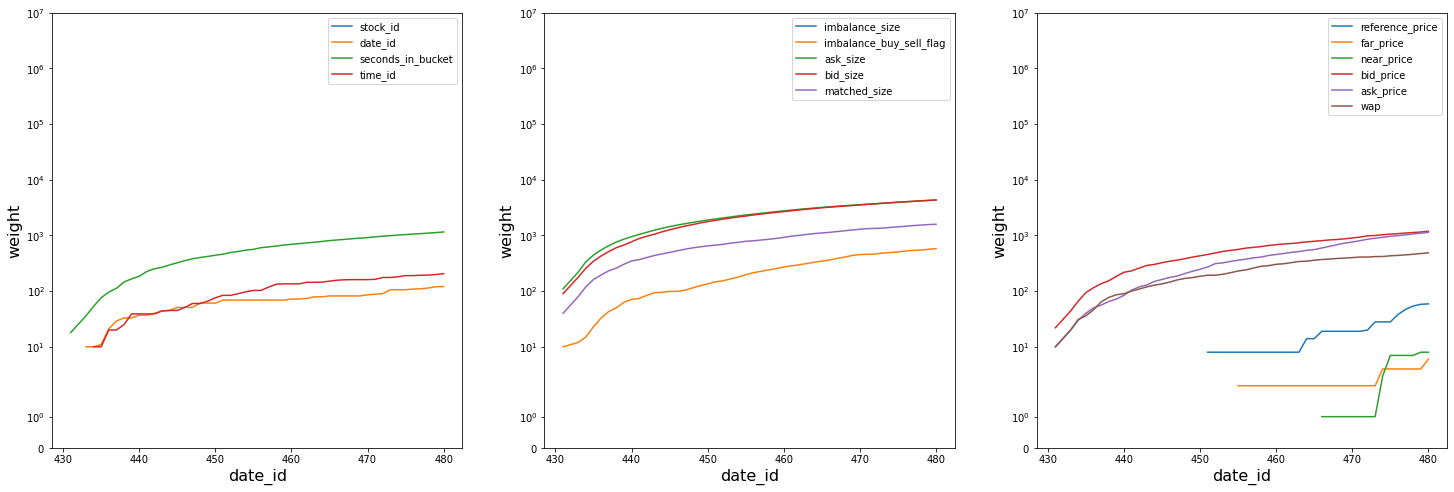

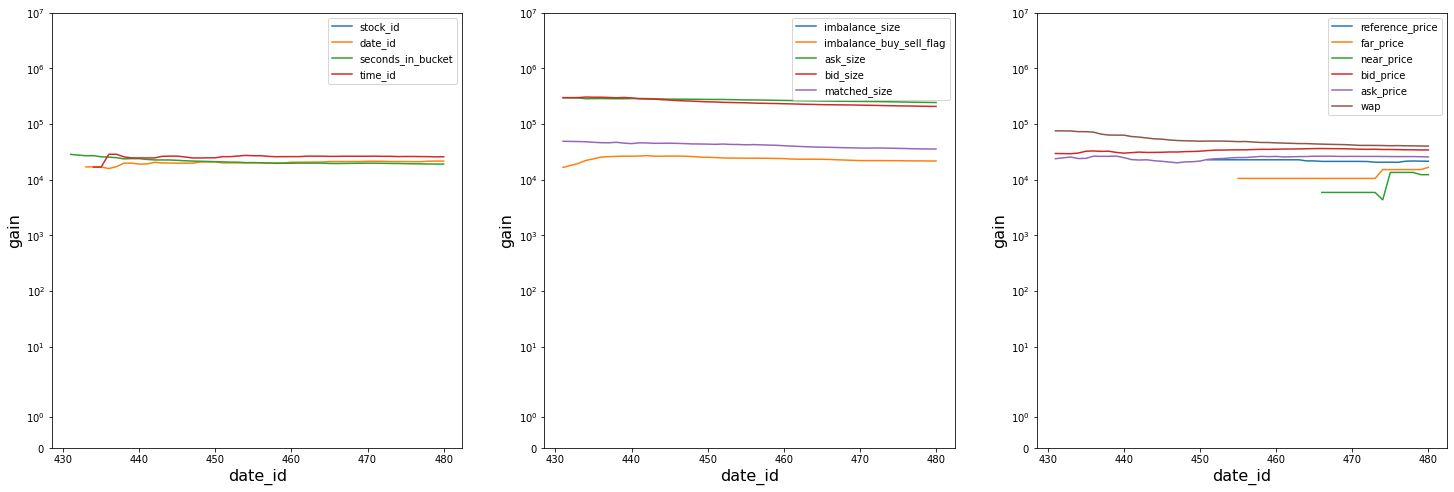

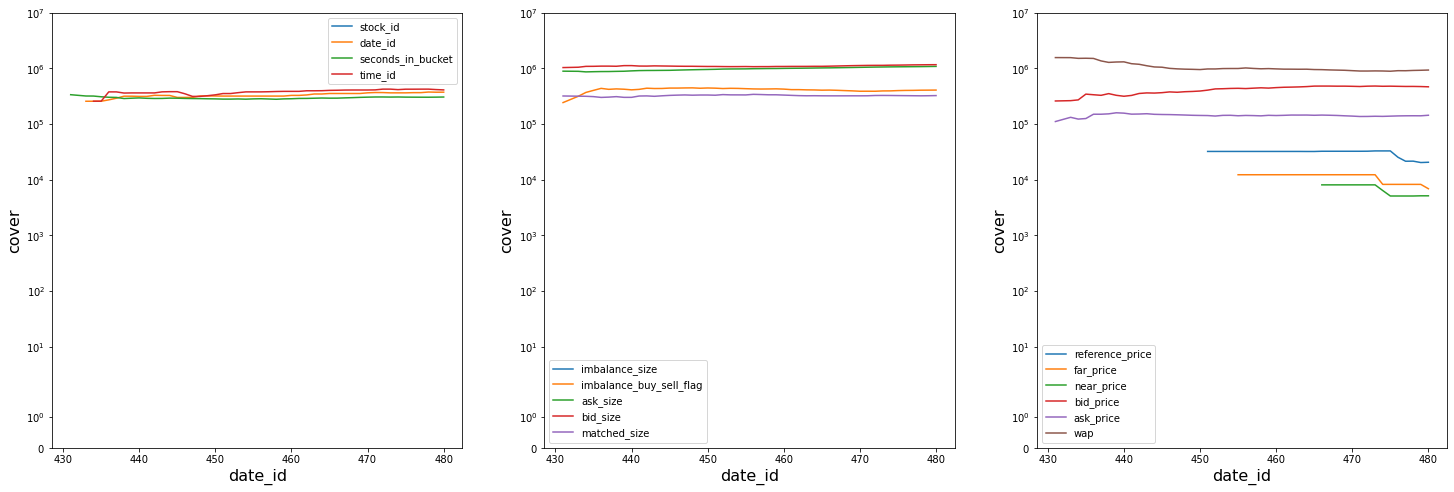

In [8]:
features_1 = ['stock_id', 'date_id', 'seconds_in_bucket','time_id']
features_2 = ['imbalance_size', 'imbalance_buy_sell_flag','ask_size','bid_size','matched_size']
features_3 = ['reference_price','far_price','near_price','bid_price','ask_price','wap']
for metric in  ['weight','gain','cover']:
    date_feature_dict = {}
    date_id_dict = {}
    for feature in X_columns:
        date_feature_dict[feature] = []
        date_id_dict[feature] = []
    for date_id in sorted(list(feature_dict.keys())):
        date_id_list =[ ]
        for feature in feature_dict[date_id][metric]:
            date_id_dict[feature].append(date_id)
            date_feature_dict[feature].append(feature_dict[date_id][metric][feature])
    f, axs = plt.subplots(1,3,figsize=(25,8))
    for feature in features_1:
        axs[0].plot(list(date_id_dict[feature]),date_feature_dict[feature],label=feature)
        axs[0].legend()
        axs[0].set_xlabel('date_id')
        axs[0].set_ylabel(metric)
        axs[0].set_yscale('symlog')
        axs[0].set_ylim(0,10**7)
    for feature in features_2:
        axs[1].plot(list(date_id_dict[feature]),date_feature_dict[feature],label=feature)
        axs[1].legend()
        axs[1].set_xlabel('date_id')
        axs[1].set_ylabel(metric)
        axs[1].set_yscale('symlog')
        axs[1].set_ylim(0,10**7)
    for feature in features_3:
        axs[2].plot(list(date_id_dict[feature]),date_feature_dict[feature],label=feature)
        axs[2].legend()
        axs[2].set_xlabel('date_id')
        axs[2].set_ylabel(metric)
        axs[2].set_yscale('symlog')
        axs[2].set_ylim(0,10**7)

In [58]:
feature_number_results_training = {}
feature_number_results_training_std = {}
feature_number_results_test = {}
feature_number_results_test_std = {}
while len(X_columns) > 1:
    print("Number of features",len(X_columns))
    number_of_stocks = 200
    number_of_bucket_iter = 55
    # Creating time series folds
    number_of_folds = 1
    total_number_of_days = 480
    fold_size =  total_number_of_days/number_of_folds
    # Test size propoprtion
    rolling_test_size_ratio = 0.1

    param_dict = {'max_depth':5,'n_estimators':10,'eta':0.001,'min_child':100,'alpha':100,'lambda':100}

    # Store the model in the dictionary
    model =xgb.XGBRegressor(base_score=0, booster='gbtree',
                             n_estimators=param_dict['n_estimators'],
                             objective="reg:squarederror",
                             max_depth=param_dict['max_depth'],
                             eta=param_dict['eta'],
                             reg_alpha =param_dict['alpha'],
                            reg_lambda =param_dict['lambda'],
                            min_child_weight =param_dict['min_child'])
    df = df[X_columns + ['target']]
    fold_dict,X_train_dict, y_train_dict,X_test_dict, y_test_dict = create_folds(number_of_folds,rolling_test_size_ratio,fold_size,df.copy())
    X_train_df, X_test_df,feature_dict = evaluate_folds(df.copy(),fold_dict.copy(),X_train_dict.copy(), y_train_dict.copy(),X_test_dict.copy(), y_test_dict.copy(),model)
    X_test_df['absolute_error'] = abs(X_test_df['target'] - X_test_df['target_pred'])
    X_train_df['absolute_error'] = abs(X_train_df['target'] - X_train_df['target_pred'])
    
    feature_number_results_training[len(X_columns)] =  X_train_df['absolute_error'].mean()
    feature_number_results_training_std[len(X_columns)]  =  X_train_df['absolute_error'].std()
    feature_number_results_test[len(X_columns)] =  X_test_df['absolute_error'].mean()
    feature_number_results_test_std[len(X_columns)]   =  X_test_df['absolute_error'].std()
    for metric in  ['weight','gain','cover']:
        date_feature_dict = {}
        date_id_dict = {}
        for feature in X_columns:
            date_feature_dict[feature] = []
            date_id_dict[feature] = []
        for date_id in sorted(list(feature_dict.keys())):
            date_id_list =[ ]
            for feature in feature_dict[date_id][metric]:
                if feature not in ['date_id','seconds_in_bucket']:
                    date_id_dict[feature].append(date_id)
                    date_feature_dict[feature].append(feature_dict[date_id][metric][feature])
    mean_feature_importance = {}
    for metric in  ['weight','gain','cover']:
        mean_feature_importance[metric] = {}
        for feature in feature_dict[date_id][metric]:
            if feature not in ['date_id','seconds_in_bucket']:
                mean_feature_importance[metric][feature] = np.mean(date_feature_dict[feature])

    # Creating a DataFrame for each metric and ranking features
    df_dict = {}
    for metric in mean_feature_importance:
        df_rank = pd.DataFrame.from_dict(mean_feature_importance[metric], orient='index', columns=[metric])
        df_rank = df_rank.sort_values(by=metric, ascending=False).rank(ascending=False)
        df_dict[metric] = df_rank

    # Merging all DataFrames to create a combined rank DataFrame
    combined_df = pd.concat(df_dict.values(), axis=1)
    combined_df['combined_rank'] = combined_df.apply(lambda x: np.mean([x['weight'],x['gain'],x['cover']]),axis=1)
    combined_df = combined_df.sort_values(by='combined_rank')
    least_important_feature = combined_df[-1:].index[0]
    X_columns.remove(least_important_feature)

Number of features 15
Creating 1 folds
Date: 432 from 432 to 480 | Total time spent on this fold 0.1 minutes ****
Date: 433 from 432 to 480 | Total time spent on this fold 0.19 minutes ****
Date: 434 from 432 to 480 | Total time spent on this fold 0.28 minutes ****
Date: 435 from 432 to 480 | Total time spent on this fold 0.38 minutes ****
Date: 436 from 432 to 480 | Total time spent on this fold 0.47 minutes ****
Date: 437 from 432 to 480 | Total time spent on this fold 0.57 minutes ****
Date: 438 from 432 to 480 | Total time spent on this fold 0.66 minutes ****
Date: 439 from 432 to 480 | Total time spent on this fold 0.76 minutes ****
Date: 440 from 432 to 480 | Total time spent on this fold 0.86 minutes ****
Date: 441 from 432 to 480 | Total time spent on this fold 0.96 minutes ****
Date: 442 from 432 to 480 | Total time spent on this fold 1.06 minutes ****
Date: 443 from 432 to 480 | Total time spent on this fold 1.16 minutes ****
Date: 444 from 432 to 480 | Total time spent on th

KeyboardInterrupt: 